# Figure 4a: PDO 21 monoculture by treatment

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scprep
import phate

from sklearn.decomposition import PCA
from MultiscaleEMD import MetricTree
import sklearn
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import OneHotEncoder

data_path = "/Users/mariaramos/Dropbox/Merged_files/"
#!ls -lah $data_path
file_name = "Metadata_final"

In [2]:
#Load metadata from file
raw_df = pd.read_pickle(data_path + file_name)

In [3]:
"""Variable: select for specific subsets of the data"""

cell_type_mask = ((raw_df['Cell_type'] == 'PDOs'))
culture_mask = ((raw_df['Culture'] == 'PDO'))
patient_mask = ((raw_df['Patient'] == '21'))
batch_mask = ((raw_df['Batch'] == 1))
plate_mask = ((raw_df['Plate'] == 'SLV'))

data_masked = raw_df.loc[culture_mask & patient_mask & cell_type_mask]


In [4]:
#Clean-up: removing pPKCa to remove NaN values - downsample 

data_masked.drop('pPKCa', axis=1, inplace=True)
# data_masked = data_masked.sample(n=1000000, random_state=1, replace=False)
data_masked.index = np.arange (data_masked.shape[0])

#Creates a tag for normalization that includes Patient + Date
def col_join(arr):
    """ Joins columns of a dataframe into a single column with underscores """
    return "_".join(np.array(arr).astype("str"))
    
norm_tags = data_masked.iloc[:, -9:-7].T.apply(col_join).rename("Norm_tag")
df_with_tags = pd.concat([data_masked, norm_tags], axis=1)

#We need to split the data to normalise the numerical columns
data_for_norm = df_with_tags.iloc[:, :-10]
non_numerical = df_with_tags.iloc[:, -10:-1]

# Arcsinh transformation and batch normalisation
data_arcs = np.arcsinh(data_for_norm / 5)
data_centered = scprep.normalize.batch_mean_center(
    data_arcs.copy(), sample_idx=df_with_tags["Norm_tag"]
)

#Re-merge the non-numerical values to the normalised data
full_centered = pd.concat([data_centered, non_numerical], axis=1)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [5]:
# Build a canonical list of names for each sample so we can order by this in
# all subsequent processing

full_names = full_centered.iloc[:, -9:].T.apply(col_join).rename("Full_name")
df_with_names = pd.concat([full_centered, full_names], axis=1)

metadata = df_with_names.iloc[:, -10:]
data = full_centered.iloc[:, :-9]

full_data = pd.concat([metadata, data], axis=1)

In [6]:
mean_locs = (
    df_with_names.groupby(
        [
            "Culture",
            "Date",
            "Treatment",
            "Concentration",
            "Replicate",
            "Cell_type",
            "Patient",
            "Full_name",
            "Batch", 
            "Plate"
        ]
    )
    .mean()
)

meta = mean_locs.index.to_frame()

# Sorting is necessary so that np.unique works for labeling the samples on the tree
# meta contains one line per sample and the metadata table associated with that sample
meta = meta.reset_index(drop=True).sort_values("Full_name").reset_index(drop=True)

In [7]:
non_sig_markers = [
    "pHH3",
    "RFP",
    "mCHERRY",
    "Vimentin",
    "EpCAM",
    "CK18",
    "Pan_CK",
    "GFP",
    "IdU",
    "cCaspase_3",
    "Geminin",
    "pRB",
    "PLK",
    "CHGA",
    "CD90",
    "cPARP",
    "Cyclin_B1",
]
data_sig = data.drop(
    non_sig_markers,
    axis=1,
    inplace=False,
)
#Cell_type markers or problematic antibodies (cCaspase_3)
cell_type_markers = [
    "RFP",
    "mCHERRY",
    "Vimentin",
    "EpCAM",
    "CK18",
    "Pan_CK",
    "GFP",
    "CHGA",
    "CD90",
    "cCaspase_3"
]


data_all = data.drop(
    cell_type_markers,
    axis=1,
    inplace=False,
)

In [8]:
# Build a subtree for each leaf phase
unique, inverse = np.unique(full_names, return_inverse=True)
assert np.array_equal(unique, meta["Full_name"].values)

thresholds = {
    "20220328_21": {
        "pRB": 0.5,
        "IdU": 2,
        "pHH3": 3,
        "Cyclin_B1": 0,
        "cPARP": -0.9,
        "pHistone_H2A":-0.2
    },
    "20210413_21": {
        "pRB": -0.5,
        "IdU": 2,
        "pHH3": 3,
        "Cyclin_B1": -1,
        "cPARP": -0.5,
        "pHistone_H2A":-0.6

    },
}

discretes = []
for norm_tag in df_with_tags["Norm_tag"].unique():
    mask = df_with_tags["Norm_tag"] == norm_tag
    discretes.append(
        pd.concat(
            [data_centered[mask][gene] > thresh for gene, thresh in thresholds[norm_tag].items()],
            axis=1,
        )
    )
discrete = pd.concat(discretes, axis=0).reindex(data.index)

tree = {
    "S_phase_H2Ahi": discrete["pRB"] & discrete["IdU"] & discrete["pHistone_H2A"],
    "S_phase_H2Alo": discrete["pRB"] & discrete["IdU"] & ~discrete["pHistone_H2A"],
    "M_phase_H2Ahi": discrete["pRB"] & ~discrete["IdU"] & discrete["pHH3"]
     & discrete["pHistone_H2A"],
    "M_phase_H2Alo": discrete["pRB"] & ~discrete["IdU"] & discrete["pHH3"]
     & ~discrete["pHistone_H2A"],
    "G2_phase_H2Ahi": discrete["pRB"] & ~discrete["IdU"] & ~discrete["pHH3"]
    & discrete["Cyclin_B1"] & discrete["pHistone_H2A"],
    "G2_phase_H2Alo": discrete["pRB"] & ~discrete["IdU"] & ~discrete["pHH3"]
    & discrete["Cyclin_B1"] & ~discrete["pHistone_H2A"],
    "G1_phase_H2Ahi": discrete["pRB"] & ~discrete["IdU"] & ~discrete["pHH3"]
    & ~discrete["Cyclin_B1"] & discrete["pHistone_H2A"],
    "G1_phase_H2Alo": discrete["pRB"] & ~discrete["IdU"] & ~discrete["pHH3"]
    & ~discrete["Cyclin_B1"] & ~discrete["pHistone_H2A"],
     "Apoptosis_H2Ahi": ~discrete["pRB"] & discrete["cPARP"] 
    & discrete["pHistone_H2A"],
    "Apoptosis_H2Alo": ~discrete["pRB"] & discrete["cPARP"] 
    & ~discrete["pHistone_H2A"],
    "G0_phase_H2Ahi": ~discrete["pRB"] & ~discrete["cPARP"] 
    & discrete["pHistone_H2A"],
    "G0_phase_H2Alo": ~discrete["pRB"] & ~discrete["cPARP"] 
    & ~discrete["pHistone_H2A"],
}

df_tree = pd.DataFrame(tree)
leaf_phases = ["S_phase_H2Ahi", "S_phase_H2Alo", "M_phase_H2Ahi", "M_phase_H2Alo",
"G2_phase_H2Ahi", "G2_phase_H2Alo", "G1_phase_H2Ahi", "G1_phase_H2Alo", "Apoptosis_H2Ahi", "Apoptosis_H2Alo", "G0_phase_H2Ahi", "G0_phase_H2Alo"
]

proportions = (
    pd.concat([metadata, df_tree], axis=1)
    .groupby(
        [
            "Culture",
            "Date",
            "Treatment",
            "Concentration",
            "Replicate",
            "Cell_type",
            "Patient",
            "Full_name",
        ]
    )
    .mean()
    .sort_values("Full_name")
    .reset_index(drop=True)
)

# Encodes
onehot = OneHotEncoder(sparse=True)
labels = onehot.fit_transform(inverse.reshape(-1, 1))

# TODO this has changed in v6
d = np.array(labels.sum(axis=0)).flatten()
labels_normed = labels.tocoo()
labels_normed.data = labels_normed.data / d[labels_normed.col]
labels_normed = labels_normed.tocsr()


def l1_embeddings(cts, edge_weights):
    return np.array(
        [np.asarray(cts)[i, :] * np.asarray(edge_weights) for i in range(len(cts))]
    )


def leaf_runner(
    data, labels, tree_type, n_trees, norm_per_subtree=False, random_state=42, **kwargs
):
    """Creates tree embeddings for each sample based on tree parameters.

    Parameters:

        data: [# cells x # features] data matrix
        labels: [# cells x # distributions] (potentially sparse) describing membership of cells to distributions
        tree_type: type of tree to build over the features
        n_trees: how many trees to build
        norm_per_subtree: whether to treat each subtree as a separate distribution,
                          this essentially weights each subtree equally, rather than weighting
                          based on how many cells are in each subtree (default)

    Returns:
        leaf_embeds: [# distributions x (n_trees x n_nodes)] embeddings one per distribution where L1 distrance
                     between embeddings represents tree EMD
        leaf_trees: Tree objects for each tree
        leaf_ids: Leaf label for each tree node [n_nodes] containing the strings of the leaf_phases
    """
    leaf_embeds = []
    leaf_trees = []
    leaf_ids = []
    # note that we only build a tree for each leaf phase leaving out proliferating vs. not
    rs = random_state
    for leaf in leaf_phases:
        mask = np.array(df_tree[leaf])
        sub_data = data[mask]
        sub_labels = labels[mask]
        if norm_per_subtree:
            d = np.array(sub_labels.sum(axis=0)).flatten()
            # Fix divide by zero errors
            d = np.clip(d, a_min=1e-8, a_max=None)
            sub_labels = sub_labels.tocoo()
            sub_labels.data = sub_labels.data / (d[sub_labels.col])
            sub_labels = sub_labels.tocsr()
        embeds = []
        mts = []
        for i in range(n_trees):
            mt = MetricTree(tree_type=tree_type, random_state=rs, **kwargs)
            counts, edge_weights = mt.fit_transform(
                X=sub_data,
                y=sub_labels,
            )
            embeds.extend(l1_embeddings(counts.todense(), edge_weights).T)
            mts.append(mt)
        embeds = np.array(embeds).T
        leaf_embeds.append(embeds)
        leaf_trees.append(mts)
        leaf_ids.append([leaf] * embeds.shape[1])
        rs += 1
    leaf_embeds = np.concatenate(leaf_embeds, axis=1)
    leaf_ids = np.concatenate(leaf_ids)
    return leaf_embeds, leaf_trees, leaf_ids


def tree_runner(data, labels, tree_type, n_trees, random_state=42, **kwargs):
    """Creates tree embeddings for each sample based on tree parameters.

    This ignores known cell state structure and simply builds a tree over the entire dataset.

    Parameters:

        data: [# cells x # features] data matrix
        labels: [# cells x # distributions] (potentially sparse) describing membership of cells to distributions
        tree_type: type of tree to build over the features
        n_trees: how many trees to build
        norm_per_subtree: whether to treat each subtree as a separate distribution,
                          this essentially weights each subtree equally, rather than weighting
                          based on how many cells are in each subtree (default)

    Returns:
        leaf_embeds: [# distributions x (n_trees x n_nodes)] embeddings one per distribution where L1 distrance
                     between embeddings represents tree EMD
        leaf_trees: Tree objects for each tree
    """
    embeds = []
    mts = []
    for i in range(n_trees):
        mt = MetricTree(tree_type=tree_type, random_state=random_state + i, **kwargs)
        counts, edge_weights = mt.fit_transform(
            X=data,
            y=labels,
        )
        embeds.extend(l1_embeddings(counts.todense(), edge_weights).T)
        mts.append(mt)
    embeds = np.array(embeds).T
    return embeds, mts


from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

In [9]:
runs = {
    "nonorm": leaf_runner(
        data_sig,
        labels_normed,
        "cluster",
        10,
        norm_per_subtree=False,
        n_levels=4,
        n_clusters=4,
    )
}

# Pairwise normalization

In [10]:
def get_dist_embeds(run):
    index = pd.MultiIndex.from_frame(
        meta.loc[:, ["Patient", "Concentration", "Culture", "Replicate", "Treatment", "Plate"]]
    )
    indexed_run = pd.DataFrame(run, index=index)
    control_run = (
        indexed_run.xs("0", level="Concentration").groupby(["Patient", "Culture", "Plate"]).mean()
    )
    diff = indexed_run - control_run
    diff = pd.DataFrame(index=index).join(diff)
    return diff

In [11]:
patients = {'11':'#da70d6', '21': '#9acd32', '23':'#cd5c5c', '27':'#7d0f0f', '75':'#808000', 
            '99':'#73B0E9', '109':'#3b65a8', '141':'#663399', '216':'#8b008b', '5': '#d42f81'}
culture = {'PDO':'#008C26', 'PDOF':'#FF7F7F', 'F':'blue'}
treatment = {'DMSO':'#000000', 'H2O':'#000000', 'AH':'#000000', 'S':'#0433FF', 'VS':'#011993', 'L':'#F2AE40', 'F':'#942193', 
             'C':'#B7933A', 'CS':'#005493', 'CSF':'#0096FF', 'SF':'#7A81FF', 'V':'#FFD479', 'CF':'#941751', 'O':'#38774F'}
concentration = {'0':60, '1':100, '2':220, '3':340, '4':460, '5':540}

In [12]:
uncentered_embeds = get_dist_embeds(runs["nonorm"][0])

phate_op = phate.PHATE(
    random_state=42,
    n_jobs=-2,
    knn_dist="manhattan",
    n_pca=None,
    verbose=False,
)
phate_coords_funct = phate_op.fit_transform(uncentered_embeds)

/Users/mariaramos/Library/Python/3.10/lib/python/site-packages/graphtools/graphs.py:118: UserWarning: Building a kNNGraph on data of shape (84, 9480) is expensive. Consider setting n_pca.
  warnings.warn(


(-0.10049438171433062,
 0.14334126197228636,
 -0.042203173059671646,
 0.12081294664699829)

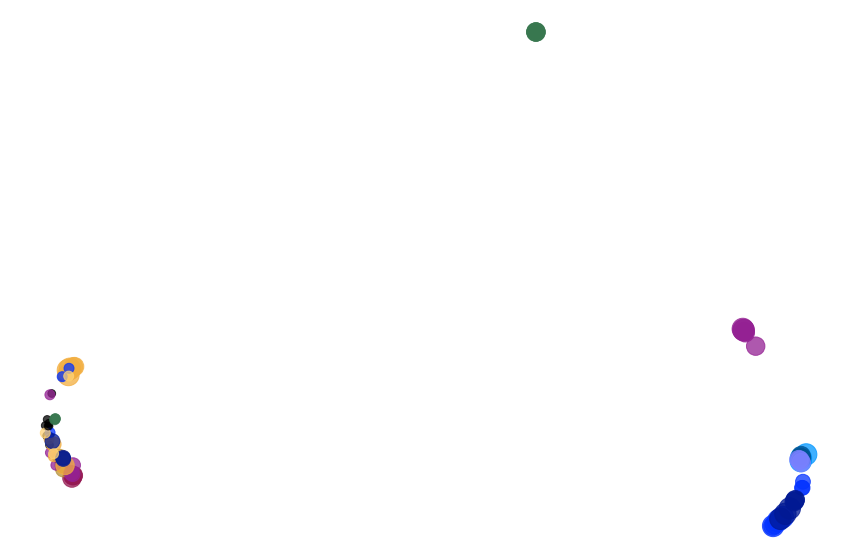

In [13]:
fig, ax = plt.subplots(1, figsize=(15,10))
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

plt.scatter(phate_coords_funct[:,0], phate_coords_funct[:,1], c=meta['Treatment'].map(treatment),
    s=meta['Concentration'].map(concentration), alpha = .75)
plt.axis('off')